# Predict occupant heating behavior from biosignal and environmental data
Using Python 3.7 and fast.ai v2

Author: Patrick Ruoff

Date: January 2020

In [1]:
import pandas as pd
import numpy as np

import data_preparation_methods as prep
import analysis_methods as ana
import scikitlearn_methods as sci
import fastai_methods as fast

seed = 42
rs = np.random.RandomState()
rs.seed(seed)

There are 3 occupants in the data set that I collected: 'U1', 'U2', or 'U3'. This notebook
is implemented to run the model_selection for one single occupant. I used it for analyzing 
the data for all three occupants one after the other. Here, I show the results for occupant 'U1'.

In [2]:
occupant = 'U2'
n_folds = 5

In [3]:
data = prep.import_data(occupant)
print(np.shape(data))

(2466, 153)


If values are still missing, they are shown here

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    prep.print_missing_entries(data)

In [5]:
if data.isna().any().any():
    print('WARNING there are still values missing!\nDeleting these rows for now..')
    data = data.drop(index=data.index[data.isna().any(axis=1)])
    

In [6]:
target = '{}_is_heating'.format(occupant)
cat_names = ['o_condition']
cont_names = data.columns.drop(cat_names).to_numpy()
print('dependency variable distribution:\n', data[target].value_counts()/data.shape[0])

dependency variable distribution:
 0.0    0.79562
1.0    0.20438
Name: U2_is_heating, dtype: float64


In [7]:
naive_acc, naive_f1, pos_label, Y_df, X_df = prep.prepare_data(
    data, target)

The target variable distribution is:
 0.0    0.79562
1.0    0.20438
Name: U2_is_heating, dtype: float64
X shape: (2466, 159)


97% of the data belongs to target value 0, meaning the heater was turned off. For the highly unbalanced distribution of the target values, I used the f1-score to compare the ML models' performances. Accuracy is also given for comparison.

For this project I designed a novel kind of interval-stratified k-fold cross-validation. It seperates 
the data into k groups by data collection-intervals. Additionally, the resulting groups are
of equal size and have an equal target variable distribution. Check the implementation 
for details. 

In [8]:
train_test_indices = prep.interval_stratified_k_fold_cross_validation(data, n_folds, target, rs, seed)

Training and validation set sizes are:
 Fold 0:   train/valid  1939/527   with 103 positive labels
 Fold 1:   train/valid  1994/472   with 109 positive labels
 Fold 2:   train/valid  1996/470   with 83 positive labels
 Fold 3:   train/valid  1924/542   with 105 positive labels
 Fold 4:   train/valid  2011/455   with 104 positive labels


In [9]:
training_attributes = {
    'occupant': occupant,
    'pos_label': pos_label,
    'X_df': X_df,
    'X_array': np.array(X_df),
    'Y_df': Y_df,
    'Y_array': np.array(Y_df),
    'train_test_indices': train_test_indices,
    'train_test_indices_int': \
    prep.transform_date_time_index_to_int(
        data, train_test_indices
    )
}

In [10]:
# ingore warnings if you know what you're doing
import warnings
warnings.filterwarnings('ignore')

In [11]:
plot_tuples = {}

# scikit-learn classification methods

In [12]:
methods = [
     'SVM-lin', 
     'RF-Clf',
     'LR',
     'GaussianNB',
     'GradientBDT',
     'kNN'
]

In [13]:
plot_tuples_new = sci.fit_scikit_learn_methods(
    methods=methods, training_attributes=training_attributes, rs=rs)
for method in plot_tuples_new:
    plot_tuples[method] = plot_tuples_new[method]

Running SVM with linear kernel and 5-Fold-Cross Validation..
Running fold 0 of 5.
Running fold 1 of 5.
Running fold 2 of 5.
Running fold 3 of 5.
Running fold 4 of 5.
Learning took 1.4094338417053223 and Inference took 0.2947506904602051 seconds.
Running Random Forest Classifier with 5-Fold-Cross Validation..
Running fold 0 of 5.
Running fold 1 of 5.
Running fold 2 of 5.
Running fold 3 of 5.
Running fold 4 of 5.
Learning took 3.01452898979187 and Inference took 0.11773991584777832 seconds.
Running Logistic Regression with 5-Fold-Cross Validation..
Running fold 0 of 5.
Running fold 1 of 5.
Running fold 2 of 5.
Running fold 3 of 5.
Running fold 4 of 5.
Learning took 0.387897253036499 and Inference took 0.03315401077270508 seconds.
Running Gaussian Naive Bayes with 5-Fold-Cross Validation..
Running fold 0 of 5.
Running fold 1 of 5.
Running fold 2 of 5.
Running fold 3 of 5.
Running fold 4 of 5.
Learning took 0.02573418617248535 and Inference took 0.028122425079345703 seconds.
Running Gradie

# fastai

fastai's tabular learner implementation was considered in pre-selection as well. 

In [14]:
from fastai.tabular import FillMissing
from fastai.tabular import Categorify
from fastai.tabular import Normalize

epochs = 5
layers = [200,200,150,100]
learning_rate = 1e-4

# set plot_tuples with results from training a fast.ai NNs
procs = [FillMissing, Categorify, Normalize]
result = fast.run_k_fold_cross_validation_fastai(
    data, training_attributes, epochs, learning_rate, cat_names,
    cont_names, target, procs, layers)

method = 'fastai'
plot_tuples[method] = result

epoch,train_loss,valid_loss,accuracy,time
0,0.864996,0.751746,0.195446,00:00
1,0.862493,0.741960,0.195446,00:00
2,0.834044,0.731287,0.195446,00:00
3,0.800630,0.720674,0.195446,00:00
4,0.770561,0.710742,0.195446,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.707918,0.690239,0.567797,00:00
1,0.705794,0.691711,0.512712,00:00
2,0.682044,0.692799,0.451271,00:00
3,0.654738,0.693462,0.413136,00:00
4,0.630430,0.694260,0.360170,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.751655,0.641303,0.823404,00:00
1,0.749355,0.647811,0.823404,00:00
2,0.723628,0.653670,0.823404,00:00
3,0.693957,0.659123,0.836170,00:00
4,0.667472,0.664712,0.914894,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.866113,0.684358,0.776753,00:00
1,0.863757,0.687229,0.750923,00:00
2,0.836328,0.691574,0.616236,00:00
3,0.803042,0.696890,0.363469,00:00
4,0.772367,0.702738,0.212177,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.664598,0.656604,0.771429,00:00
1,0.662490,0.655421,0.771429,00:00
2,0.638671,0.653286,0.771429,00:00
3,0.610937,0.650608,0.771429,00:00
4,0.586091,0.648077,0.771429,00:00


# Plot results

In [15]:
df_test_accs, acc_ranks, df_test_f1s, f1_ranks = ana.prepare_plot_of_kfold_cv(
    plot_tuples)

The ordered accuracies are:  [(b'RF-Clf', 0.947061) (b'GradientBDT', 0.947061) (b'GaussianNB', 0.930908) (b'LR', 0.866419) (b'kNN', 0.846406)
 (b'SVM-lin', 0.828066) (b'fastai', 0.490823)]
The ordered f1-scores are:  [(b'RF-Clf', 0.964299) (b'GradientBDT', 0.964299) (b'GaussianNB', 0.954477) (b'LR', 0.913312) (b'kNN', 0.905409)
 (b'SVM-lin', 0.897406) (b'fastai', 0.459863)]


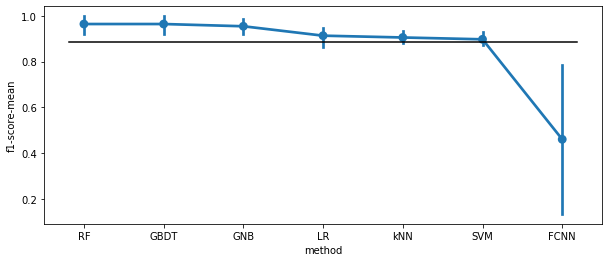

In [16]:
ana.plot_f1s(df_test_f1s, naive_f1,
           store_path='plots/{}_F1-Scores.png'.format(occupant))

fastai could not keep up with the scikit-learn ML
methods and was therefore left out for the following paramter opitmization for this particular occupant.

Therefore, all the other ML methods were parameter optimized in ```optimize

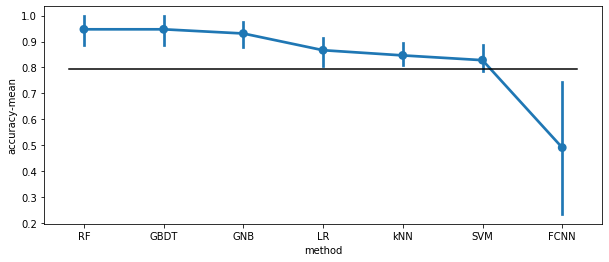

In [17]:
ana.plot_accs(df_test_accs, naive_acc,
            store_path='plots/{}_Accuracies.png'.format(occupant))

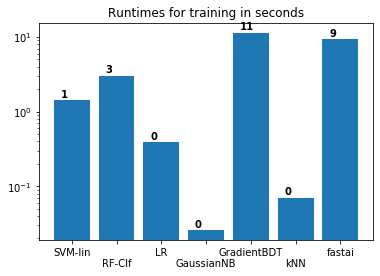

In [18]:
ana.plot_training_times(plot_tuples, 
                store_path='plots/{}_Runtimes.png'.format(occupant))

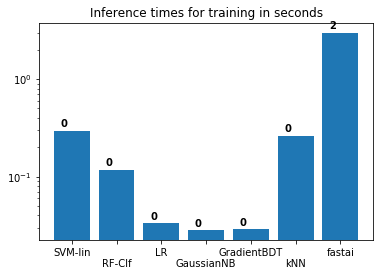

In [19]:
ana.plot_inference_times(plot_tuples, 
                store_path='plots/{}_InferenceTimes.png'.format(occupant))

In check_random_search_results.ipynb I compare the results of this randomized search. 
Afterwards, I checked the results in check_random_search_results to see
which method performed best. 
Then I ran refit_with_optimized_parameters.ipynb to refit all the models with 
the optimal parameters with three different seeds as is good practice.
